# Анализ оттока клиентов банка и сегментация отточных клиентов

**Материалы:**
* [Презентация](https://disk.yandex.ru/i/6ZTTvL9bunsCXw)
* [Дашборд](https://public.tableau.com/app/profile/alex.glotov/viz/Banksclientsresearch/Dashboard1)

Отдел маркетинга банка "Метанпром" поставил задачу проанализировать клиентов и выделить сегменты пользователей, которые склонны уходить из банка. Это необходимо для того, чтобы для каждого сегмента была возможность составить более индивидуальную рекламную компанию с целью удержать клиентов.

Для работы предоставлен датасет, который содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. По клиентам дана следующая информация: ID пользователя, баллы кредитного скоринга, город, пол, возраст, количество баллов собственности, баланс на счете, количество продуктов, которыми пользуется клиент, наличие кредитной карты, активный клиент или нет, зарплата клиента, ушел клиент или остался.

**Цель работы:** выполнить анализ пользователей банка, выделить сегменты отточных клиентов, дать рекомендации по снижению оттока клиентов и подготовить презентацию.

## Загрузка данных и изучение общей информации

Загрузим датасет, подготовим описание данных и изучим основную информацию о датасете (типы переменных в каждом столбце, количество пропусков и полных дубликатов строк, описательные статистики по числовым переменным, значения категориальных переменных).

Импортируем все необходимые библиотекки для работы с данными.

In [1]:
import phik
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as st
import plotly.graph_objects as go
from scipy import stats as st
from sklearn import tree, ensemble
from matplotlib import pyplot as plt

import plotly.io as pio
pio.renderers.default = 'png'
pio.renderers['png'].scale = 1.2

Загрузим предоставленный датасет.

In [2]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
df = pd.read_csv(path)

Выведем первые 5 строк датасета.

In [3]:
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Описание данных:**

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город местонахождения филиала банка,
- `gender` — пол,
- `age` — возраст,
- `equity`  — количество баллов собственности,
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `est_salary` — заработная плата клиента,
- `churn` — ушёл клиент или нет.

Приведем названия столбцов к нижнему регистру.

In [4]:
df.columns = df.columns.str.lower()

Посмотрим всю информацию о датафрейме. Для этого воспользуемся ранее созданной функцией.

In [5]:
def describe_all(data, unique_vals=20):
    '''Функция, которая выводит подробное описание данных датафрейма.
    
    Функция принимает на вход датафрейм и выводит информацию о датафрейме, описание переменных,
    количество полных дубликатов строк, а также количество уникальных значений в каждом из столбцов,
    содержащих переменные типа 'object'. Количество уникальных значений можно указать во втором параметре функции
    (по умолчанию 20).
    '''
    
    print('Информация о датафрейме')
    data.info()
    print('-'*20)
    print()
    
    print('Описание датафрейма')
    display(data.describe())
    print('-'*20)
    print()
    
    print('Количество полных дубликатов строк:', data.duplicated().sum())
    print('-'*20)
    print()
    
    for i in data.select_dtypes(include=['object']).columns:
        print(f'Количество уникальных значений в столбце {i}: {data[i].nunique()}')
        if data[i].nunique() <= unique_vals:
            print(f'Список уникальных значений {data[i].unique()}')
            print('- '*10)
        else:
            print(f'Уникальных значений более {unique_cat_vals}')


In [6]:
describe_all(df)

Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
--------------------

Описание датафрейма


,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


--------------------

Количество полных дубликатов строк: 0
--------------------

Количество уникальных значений в столбце city: 3
Список уникальных значений ['Рыбинск' 'Ярославль' 'Ростов']
- - - - - - - - - - 
Количество уникальных значений в столбце gender: 2
Список уникальных значений ['Ж' 'М']
- - - - - - - - - - 


Полные дубликаты строк отсутствуют. В датафрейме имеются пропуски в столбцах age (26 пропусков) и balance (2295 пропусков). 

Посмотрим на показатель оттока по всему датафрейму.

In [7]:
print('Показатель оттока по всему датафрейму: ', df.churn.mean())

Показатель оттока по всему датафрейму:  0.182


Также посмотрим на распределение клиентов по городу филиала банка и по полу.

In [8]:
for i in ['city', 'gender']:
    display(df.groupby(i)['userid'].count())

city
Ростов       1417
Рыбинск      2695
Ярославль    5888
Name: userid, dtype: int64

gender
Ж    4995
М    5005
Name: userid, dtype: int64

## Предобработка данных

Проверим числовые переменные на наличие аномальных значений. Выполним анализ пропущенных значений и обработаем либо удалим пропуски. Выполним проверку на наличие неявных дубликатов. Проведем кодирование категориальных переменных для анализа корреляции.

### Обработка пропусков

На предыдущем этапе обнаружено 2295 пропусков в столбце `balance`. Посмотрим распределения всех переменных для пользователей, которые имеют такие пропуски.

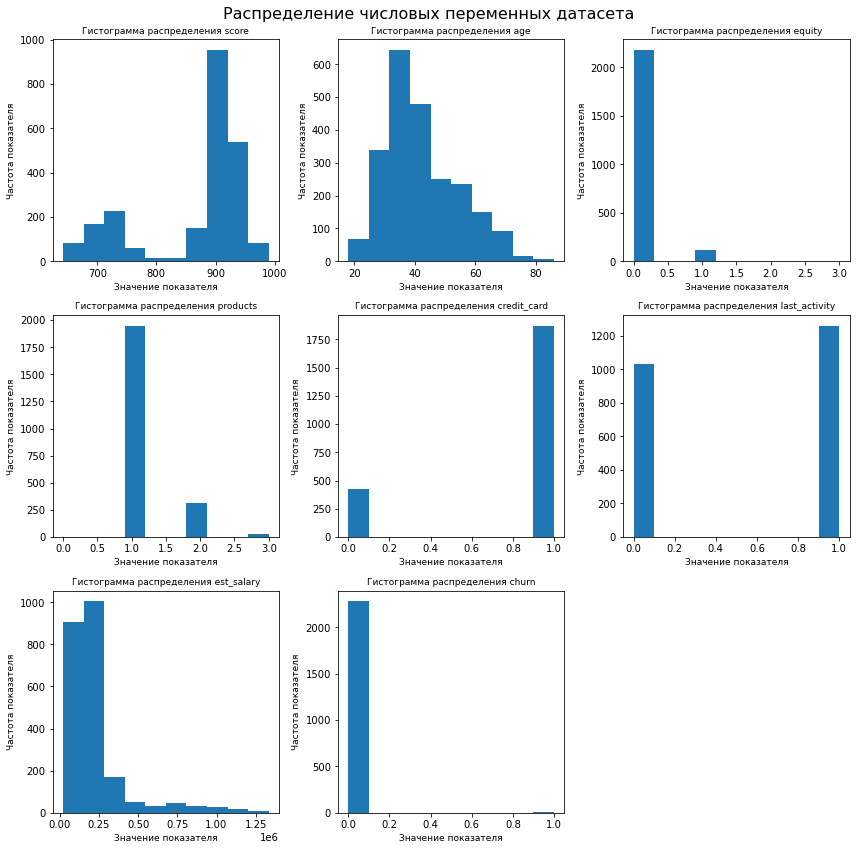

In [9]:
fig = plt.figure(figsize=(12,12))
fig.suptitle('Распределение числовых переменных датасета', fontsize=16)

for i, name in enumerate(df[df['balance'].isna()].drop(['balance','userid'], axis=1).select_dtypes(exclude=['object']).columns):
    
    ax = plt.subplot(
        int(np.ceil(len(df[df['balance'].isna()]
                        .drop(['balance','userid'], axis=1)
                        .select_dtypes(exclude=['object']).columns)/3)), 3, i+1
    )
    ax.hist(df[df['balance'].isna()][name])
    
    ax.set_title(f'Гистограмма распределения {name}', size=9)
    ax.set_xlabel(f'Значение показателя', size=9)
    ax.set_ylabel('Частота показателя', size=9)
    
plt.tight_layout()
plt.show()

Отметим, что среди пользователей с пропусками в параметре `balance` почти все из них имеют показатель `equity` равный нулю. Все отфильтрованные клиенты пользуются 1 или 2 продуктами банка, также среди всех клиентов большинство имеет кредитную карту. Под выделенным фильтром практически все пользователи являются неотточными.

Исследуем пропущенные значения в столбце `balance`. Для этого создадим датафрейм `balance_nan`, в котором категоризируем значения баланса в зависимости от того, является значение пропуском или нет ("Пропуск", "Не пропуск").

In [10]:
balance_nan = (
    df.assign(balance = df.balance.apply(lambda x: 'Не пропуск' if x == x else 'Пропуск'))
    .drop(columns=('userid'), axis=0)
)
balance_nan['balance_cat'] = balance_nan['balance'].map({'Не пропуск': 0, 'Пропуск' : 1})

Выведем датафрейм на экран.

In [11]:
balance_nan

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_cat
0,850.0,Рыбинск,Ж,25.0,1,Не пропуск,2,0,1,75719.14,1,0
1,861.0,Рыбинск,Ж,37.0,5,Не пропуск,3,1,0,86621.77,0,0
2,892.0,Рыбинск,Ж,30.0,0,Пропуск,1,1,1,107683.34,0,1
3,866.0,Ярославль,Ж,51.0,5,Не пропуск,2,0,1,174423.53,1,0
4,730.0,Ярославль,М,34.0,5,Не пропуск,1,1,0,67353.16,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,814.0,Рыбинск,М,27.0,1,Не пропуск,1,0,1,18943.64,0,0
9996,894.0,Ярославль,М,46.0,0,Пропуск,1,1,0,196898.29,0,1
9997,903.0,Ярославль,М,24.0,0,Пропуск,2,1,1,108905.09,0,1
9998,777.0,Ярославль,Ж,68.0,3,Не пропуск,3,0,1,86874.90,0,0


Посмотрим на распределение переменных `score`, `age`, `est_salary` в разрезе Наличия пропусков. Для удобства интерпретации в гистограмме распределения `est_salary` ограничим значения по оси "Х" 95-м перцентилем значений параметров.

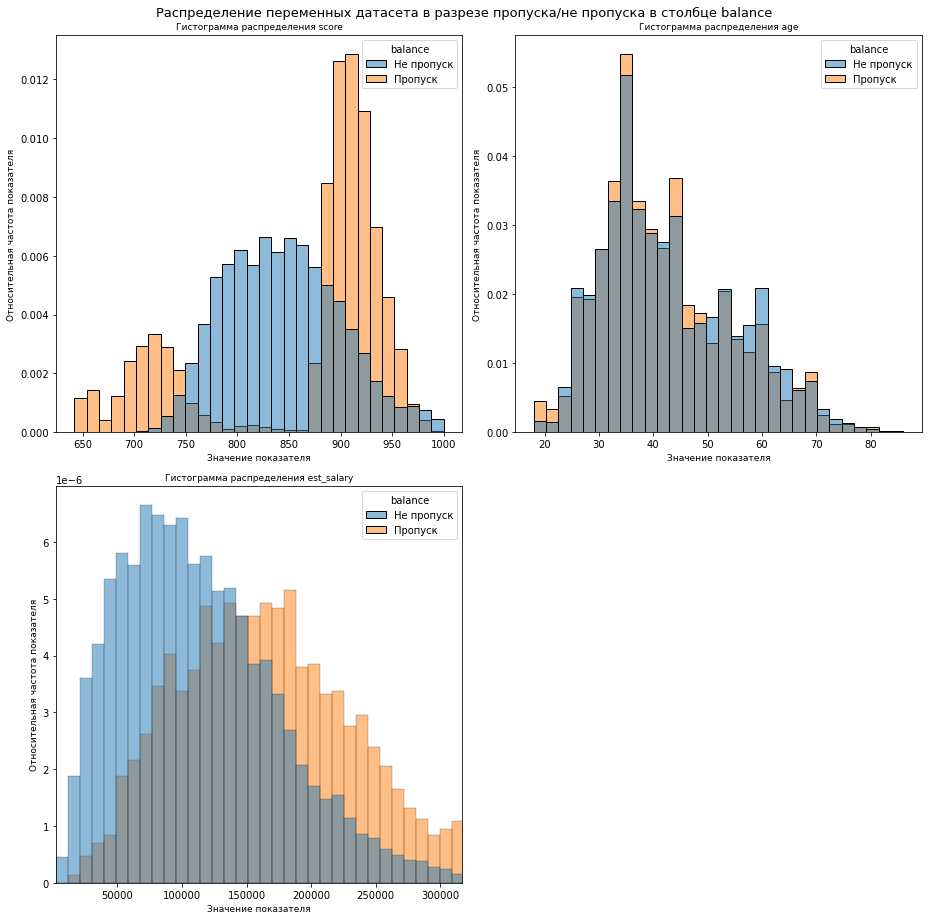

In [12]:
mask = balance_nan.select_dtypes(exclude=['object']).apply(pd.Series.nunique) > 10

fig = plt.figure(figsize=(13,13))
fig.suptitle('Распределение переменных датасета в разрезе пропуска/не пропуска в столбце balance', fontsize=13)

for i, name in enumerate(mask.index[mask]):
    if df[name].nunique() < 10:
        bins = balance_nan[name].max() - balance_nan[name].min() + 1
    if name == 'est_salary':
        bins = 150
    else:
        bins = 30
    ax = plt.subplot(int(np.ceil(len(mask.index[mask])/2)), 2, i+1)
    sns.histplot(balance_nan, x=name, hue='balance', stat='density', common_norm=False, ax=ax, bins=bins)
    ax.set_title(f'Гистограмма распределения {name}', size=9)
    ax.set_xlabel(f'Значение показателя', size=9)
    ax.set_ylabel('Относительная частота показателя', size=9)
    if name == 'est_salary':
        ax.set_xlim(balance_nan[name].min(), np.percentile(balance_nan[name], 95))
    
plt.tight_layout()    
plt.show()

Пропущенные значения часто встречаются в диапазонах `score` 650-750 и 890-970 и у клиентов с зарплатой более 100000 руб. Наличие пропусков не зависит от возраста клиента.

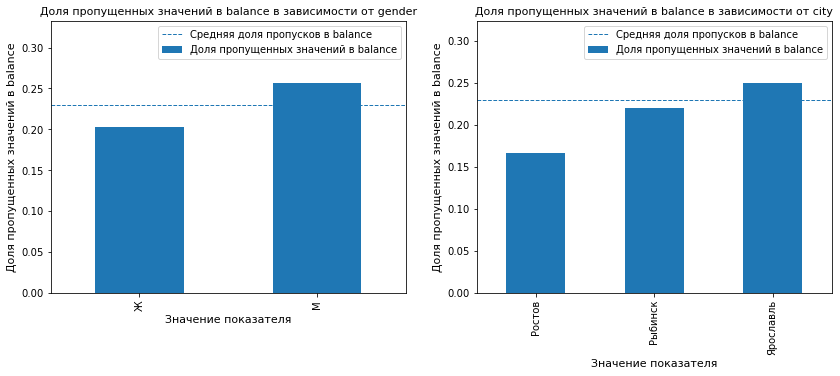

In [13]:
fig = plt.figure(figsize=(14,5))

for i, name in enumerate(['gender', 'city']):
    ax = plt.subplot(1, 2, i+1)
    (
        balance_nan.pivot_table(index=name, values='balance_cat', aggfunc='mean')
        .plot(kind='bar', ax=ax, legend=False)
    )
    ax.set_title(f'Доля пропущенных значений в balance в зависимости от {name}', size=11)
    ax.set_xlabel(f'Значение показателя', size=11)
    ax.set_ylabel('Доля пропущенных значений в balance', size=11)
    ax.axhline(y=balance_nan['balance_cat'].mean(), linestyle='--', linewidth=1, label='Средняя доля пропусков в balance')
    ax.legend().get_texts()[1].set_text('Доля пропущенных значений в balance')
    ax.set_ylim(top=(balance_nan.pivot_table(index=name, values='balance_cat', aggfunc='mean').max().values[0])*1.3)

plt.show()

Пропущенных значений в параметре `balance` среди мужчин больше (незначительно). Пропусков меньше всего среди пользователей из Ростова.

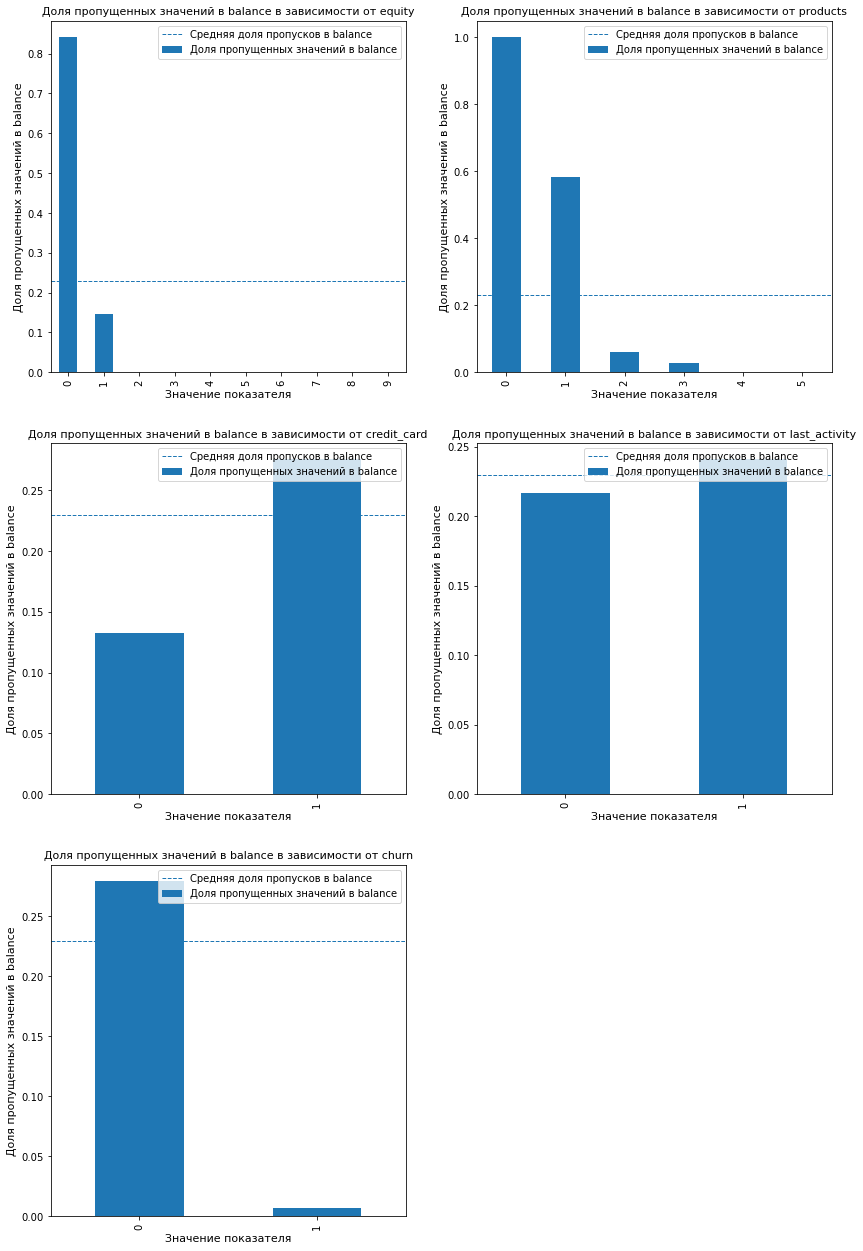

In [14]:
mask = balance_nan.select_dtypes(exclude=['object']).apply(pd.Series.nunique) <=10

fig = plt.figure(figsize=(14,22))

for i, name in enumerate(mask.index[mask].drop(['balance_cat'])):
    ax = plt.subplot(int(np.ceil(len(mask.index[mask].drop('balance_cat'))/2)), 2, i+1)
    (
        balance_nan.pivot_table(index=name, values='balance_cat', aggfunc='mean')
        .plot(kind='bar', ax=ax, legend=False)
    )
    ax.set_title(f'Доля пропущенных значений в balance в зависимости от {name}', size=11)
    ax.set_xlabel(f'Значение показателя', size=11)
    ax.set_ylabel('Доля пропущенных значений в balance', size=11)
    ax.axhline(y=balance_nan['balance_cat'].mean(), linestyle='--', linewidth=1, label='Средняя доля пропусков в balance')
    ax.legend().get_texts()[1].set_text('Доля пропущенных значений в balance')

plt.show()

Пропуски в столбце `balance` чаще всего встречаются среди пользователей с количеством продуктов равным одному, реже двум или трем (с количеством продуктов равным нулю в датафрейме всего один клиент).Доля клиентов с пропусками параметра `balance` среди тех, кто имеет кредитную карту больше. Также можно отметить, что доля клиентов с пропусками баланса среди неотточных пользователей значительно больше.

Пропуски в столбце `balance` можно классифицировать как MNAR (отсутствуют не случайно). Исходя из написанного выше, можно сделать следующий вывод: пропуски в столбце "баланс" означают, что такие клиенты пользуются только кредитными продуктами банка, либо эти клиенты новые и ещё не успели оформить дебетовую карту. То есть пропуск в столбце `balance` означает, что у клиента нет дебетовой карты. Для того, чтобы не искажать результаты анализа, не будем заполнять или удалять пропущенные значения.

Для определения возможности заполнения пропусков в столбце `age` посмотрим на корреляцию возраста с другими переменными.

In [15]:
df.corr()['age'].to_frame().style.background_gradient(cmap='coolwarm')

,age
userid,0.017795
score,-0.011814
age,1.000000
equity,0.020628
balance,0.069745
products,0.017182
credit_card,-0.123128
last_activity,-0.008157
est_salary,-0.039598
churn,-0.049797


Корреляция значения возраста со всеми количественными переменными очень слабая.

Выведем пользователей, для которых не указан возраст.

In [16]:
df[df['age'].isna()]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


Выведем описательную статистику пользователей с пропусками параметра "возраст".

In [17]:
df[df['age'].isna()].describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,26.00000,26.000000,0.0,26.000000,1.000000e+01,26.000000,26.000000,26.000000,26.000000,26.000000
mean,194637.50000,855.153846,NaN,1.384615,1.250034e+06,1.346154,0.769231,0.769231,178585.199231,0.038462
std,31310.54801,83.418316,NaN,1.961161,2.265235e+06,0.561591,0.429669,0.429669,175135.552768,0.196116
min,127440.00000,663.000000,NaN,0.000000,1.715102e+05,1.000000,0.000000,0.000000,55073.630000,0.000000
25%,185142.00000,827.500000,NaN,0.000000,2.523268e+05,1.000000,1.000000,1.000000,77807.760000,0.000000
50%,208447.00000,888.500000,NaN,0.000000,4.173611e+05,1.000000,1.000000,1.000000,142598.860000,0.000000
75%,219224.25000,919.250000,NaN,3.000000,1.039439e+06,2.000000,1.000000,1.000000,176991.690000,0.000000
max,228075.00000,942.000000,NaN,5.000000,7.601719e+06,3.000000,1.000000,1.000000,922080.250000,1.000000


Выведем описательную статистику пользователей с заполненным параметром "возраст".

In [18]:
df[df['age'].notna()].describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9974.000000,9974.000000,9974.000000,9974.000000,7.695000e+03,9974.000000,9974.000000,9974.000000,9.974000e+03,9974.000000
mean,171755.218669,848.682575,42.734409,2.630840,8.272456e+05,1.871466,0.680168,0.522859,1.477868e+05,0.182374
std,33695.527126,65.399720,12.179971,1.979965,1.980327e+06,0.792729,0.466435,0.499502,1.392855e+05,0.386172
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142760.000000,802.000000,33.000000,0.000000,2.956987e+05,1.000000,0.000000,0.000000,7.525166e+04,0.000000
50%,172643.000000,853.000000,40.000000,3.000000,5.242953e+05,2.000000,1.000000,1.000000,1.196268e+05,0.000000
75%,201163.750000,900.000000,51.000000,4.000000,9.800512e+05,2.000000,1.000000,1.000000,1.744998e+05,0.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


Клиенты с пропусками в столбце `age` имеют приблизительно те же описательные статистики, что и клиенты без пропусков. Можно классифицировать пропуски в столбце `age` как MCAR (отсутствует совершенно случайно). Пользователей с пропусками показателя "возраст" в датафрейме всего 26. Для дальнейшей работы заполним эти пропуски медианным значением.

In [19]:
df['age'] = df['age'].fillna(df['age'].median())

### Проверка на наличие и обработка неявных дубликатов

Проверим, встречаются ли в датасете неуникальные ID пользователей.

In [20]:
df[df['userid'].isin(df[df.userid.duplicated()]['userid'])]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0
9785,168998,895.0,Рыбинск,М,44.0,0,282653.53,3,0,0,255296.47,0
9819,140934,832.0,Рыбинск,Ж,40.0,3,385763.16,2,0,1,59651.35,0
9880,217412,886.0,Ярославль,Ж,35.0,3,1026172.14,2,1,0,53099.16,0


In [21]:
df.userid.duplicated().sum()

73

Имеется 73 неуникальных ID. Выведем на экран все строки с такими ID.

In [22]:
non_un = df[df['userid'].isin(df[df.userid.duplicated()]['userid'])].sort_values(['userid', 'age'])

In [23]:
non_un.head(20)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1


In [24]:
non_un.city.unique()

array(['Ярославль', 'Рыбинск'], dtype=object)

Неуникальные ID только у пользователей из Ярославля и Рыбинска.

Взаимосвязи параметров между записями с одинаковыми ID не выявлено. Вероятно появление одинаковых ID связанос технической ошибкой. Присвоим каждому повторяющемуся ID дополнительный индекс, чтобы сделать их уникальными (например, 218868, 218868_0).

In [25]:
df.userid = df.userid.astype('str')

In [26]:
df.loc[(df['userid'].duplicated()), 'userid'] = df['userid'].apply(lambda x: x + '_0')

Проверим, все ли ID уникальны.

In [27]:
df.userid.duplicated().sum()

0

Все ID уникальны.

### Исследование аномальных значений

Посмотрим на распределение всех числовых переменных.

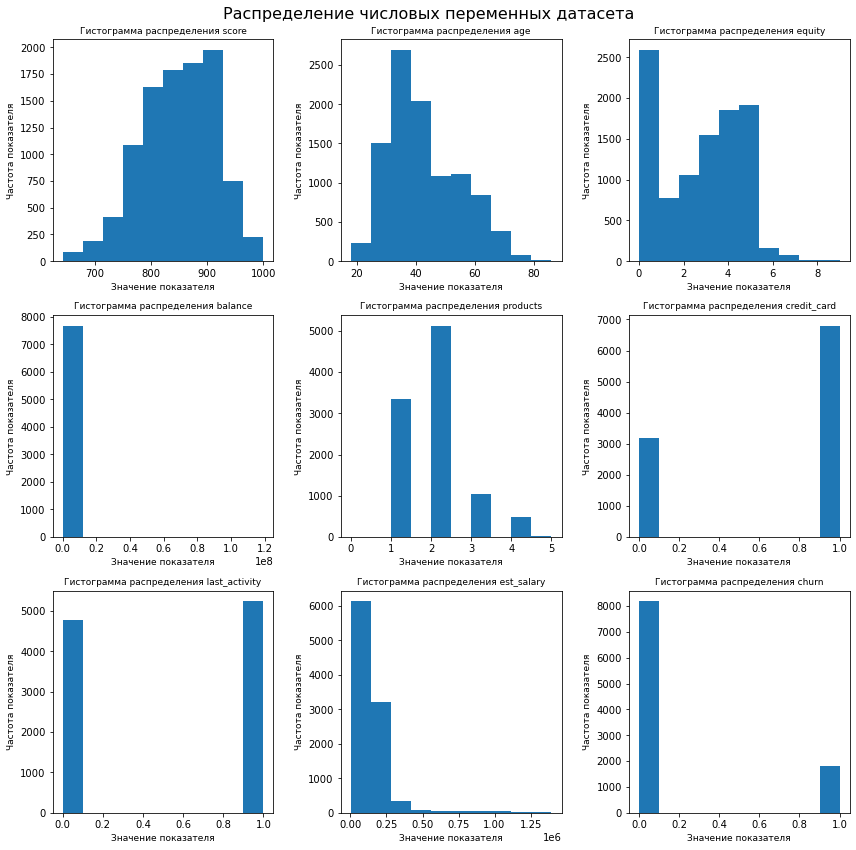

In [28]:
fig = plt.figure(figsize=(12,12))
fig.suptitle('Распределение числовых переменных датасета', fontsize=16)

for i, name in enumerate(df.select_dtypes(exclude=['object']).columns):
    
    ax = plt.subplot(int(np.ceil(len(df.select_dtypes(exclude=['object']).columns)/3)), 3, i+1)
    ax.hist(df[name])
    
    ax.set_title(f'Гистограмма распределения {name}', size=9)
    ax.set_xlabel(f'Значение показателя', size=9)
    ax.set_ylabel('Частота показателя', size=9)
    
plt.tight_layout()
plt.show()

Отметим, что распределения параметров `balance`, `est_salary` жирнохвостовые, в них имеются аномальные значения показателей.

Для принятия решения о том, удалять или оставить аномальные значения, посмотрим, имеют ли клиенты с аномальными значениями в столбцах `balance` и `est_salary` больший показатель оттока, чем остальные пользователи. Если показатель оттока для клиентов с аномальными значениями будет больше, аномальные значения удалять не следует.

Установим границу аномальных значений по 95 перцентилю и посмотрим на долю отточных клиентов с балансом ниже 95 перцентиля и выше 95 перцентиля.

In [29]:
print('95-й перцентиль по значениям в столбце balance:')
print(round(np.percentile(df['balance'].dropna(), 95)))

95-й перцентиль по значениям в столбце balance:
2116705


In [30]:
print(f'Количество клиентов, у которых баланс больше {round(np.percentile(df["balance"].dropna(), 95), 2)}:')
print(df[(df['balance'] > np.percentile(df['balance'].dropna(), 95))].shape[0])

print(f'Показатель оттока для клиентов, у которых баланс меньше {round(np.percentile(df["balance"].dropna(), 95), 2)}:')
print(round(df[df['balance'] <= np.percentile(df['balance'].dropna(), 95)].churn.mean(), 2))

print(f'Показатель оттока для клиентов, у которых баланс больше {round(np.percentile(df["balance"].dropna(), 95), 2)}:')
print(round(df[df['balance'] > np.percentile(df['balance'].dropna(), 95)].churn.mean(), 2))

Количество клиентов, у которых баланс больше 2116704.78:
386
Показатель оттока для клиентов, у которых баланс меньше 2116704.78:
0.22
Показатель оттока для клиентов, у которых баланс больше 2116704.78:
0.48


У пользователей с балансом более 2116705 отточных клиентов значительно больше, чем у остальных пользователей. Клиентов с аномальными значениями баланса не следует удалять из датасета.

Также становим границу аномальных значений по 95 перцентилю и посмотрим на долю отточных клиентов с зарплатой ниже 95 перцентиля и выше 95 перцентиля.

In [31]:
print('95-й перцентиль по значениям в столбце est_salary:')
print(round(np.percentile(df['est_salary'], 95)))

95-й перцентиль по значениям в столбце est_salary:
316885


In [32]:
print(f'Количество клиентов, у которых зарплата больше {round(np.percentile(df["est_salary"], 95), 2)}:')
print(df[(df['est_salary'] > np.percentile(df['est_salary'], 95))].shape[0])

print(f'Показатель оттока для клиентов, у которых зарплата меньше {round(np.percentile(df["est_salary"], 95), 2)}:')
print(round(df[df['est_salary'] <= np.percentile(df['est_salary'], 95)].churn.mean(), 2))

print(f'Показатель оттока для клиентов, у которых зарплата больше {round(np.percentile(df["est_salary"], 95), 2)}:')
print(round(df[df['est_salary'] > np.percentile(df['est_salary'], 95)].churn.mean(), 2))

Количество клиентов, у которых зарплата больше 316885.34:
500
Показатель оттока для клиентов, у которых зарплата меньше 316885.34:
0.18
Показатель оттока для клиентов, у которых зарплата больше 316885.34:
0.16


У пользователей с зарплатой более 316885 отточных клиентов приблизительно столько же, как у остальных пользователей.

Посмотрим, сколько клиентов окажется на пересечении двух групп: клиенты с балансом более 1838868 и клиенты с зарплатой более 316885.

In [33]:
print(f'Количество клиентов, у которых зарплата больше {round(np.percentile(df["est_salary"], 95), 2)}')
print(f'и баланс больше {round(np.percentile(df["balance"].dropna(), 95), 2)}:')
print(
    df[(df['est_salary'] > np.percentile(df['est_salary'], 95)) & (df['balance'] > np.percentile(df['balance'].dropna(), 95))]
    .shape[0])

Количество клиентов, у которых зарплата больше 316885.34
и баланс больше 2116704.78:
121


Таких клиентов 121. Пользователей с аномальными значениями баланса отсекать также не следует, поскольку мы можем удалить часть клиентов с большим показателем оттока и исказить данные.

### Кодирование категориальных переменных

Для корреляционного анализа необходимо выполнить кодирование категориальных переменных (`city` и `gender`). Эти переменные являются неупорядоченными, т.е. не имеют какого либо численного порядка, либо ранга, поэтому для них будет применено one-hot кодирование.

Для коридования пола клиента создадим колонку `is_man`, которая будет показывать, является клиент мужчиной (значение 1) или нет (значение 0).

In [34]:
df.insert(4, 'is_man', df['gender'].replace({'Ж':0 , 'М':1}))

In [35]:
df.head()

,userid,score,city,gender,is_man,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,0,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,0,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,0,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,0,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,1,34.0,5,174.00,1,1,0,67353.16,1


Для кодирования переменной `city`, создадим копию одноименного столбца и передадим ее методу `get_dummies`, который создаст столбцы с названиями городов и в каждом из них укажет, является ли пользователь клиентом филиала в данном городе (1) или нет (0). Таким образом для каждого клиента будет проставлено значение 1 в одном из столбцов с названием города, в остальных будет значение 0.

In [36]:
df['city_for_cat'] = df['city']

In [37]:
df = pd.get_dummies(df, columns=['city_for_cat'], prefix=['city'])

In [38]:
df.head()

,userid,score,city,gender,is_man,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль
0,183012,850.0,Рыбинск,Ж,0,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0
1,146556,861.0,Рыбинск,Ж,0,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0
2,120722,892.0,Рыбинск,Ж,0,30.0,0,NaN,1,1,1,107683.34,0,0,1,0
3,225363,866.0,Ярославль,Ж,0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,157978,730.0,Ярославль,М,1,34.0,5,174.00,1,1,0,67353.16,1,0,0,1


В результате предобработки данных обработаны пропуски в данных, выявлены и обработаны неявные дубликаты в столбце `userid` и выполнено кодирование категориальных переменных `city` и `gender`. По итогам исследования записей с аномальными значениями в столбцах `balance` и `est_salary` принято решение не удалять их, т.к. записи с аномальными значениями имеют высокий показатель оттока и удаление может значительно исказить результаты исследования.

## Разведочный анализ данных (EDA)

Выполним анализ распределения признаков в разрезе оттока.

Составим портрет отточного и неотточного клиента. Для его описания применим средние/медианные значения рассмотренных признаков.

Проанализируем корреляции признака оттока с остальными признаками и интерпретируем значения по шкале Чеддока.

Посмотрим на распределение переменных `score`, `age`, `balance`, `est_salary` в разрезе оттока. Для удобства интерпретации в гистограммах распределения `est_salary` и `balance` ограничим значения по оси "Х" 95-м перцентилем значений параметров.

In [39]:
df.query('score > 820 & score < 940').churn.mean()

0.22916666666666666

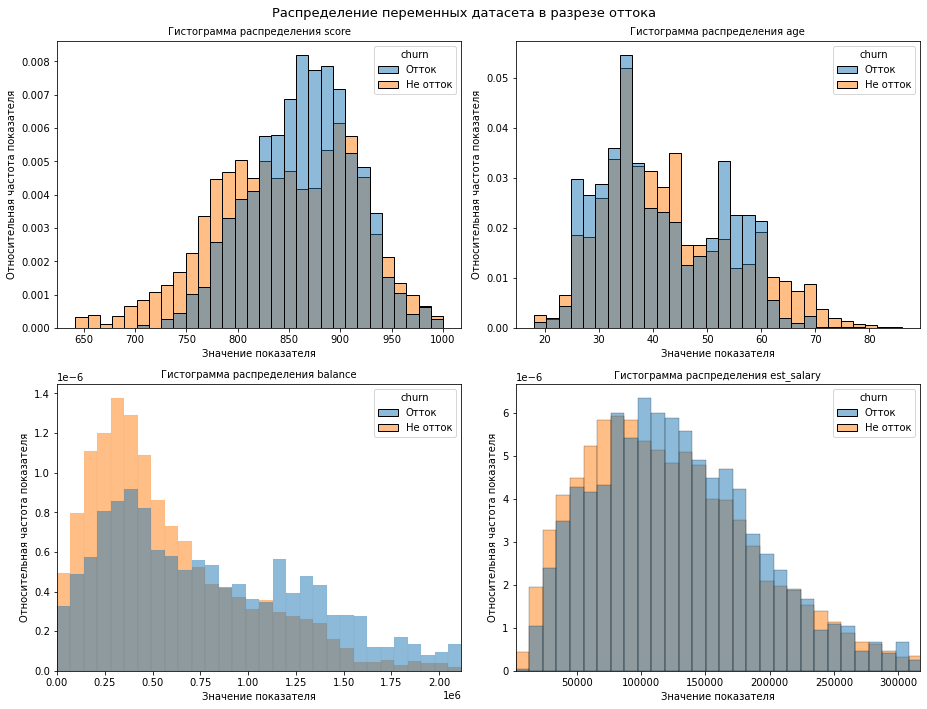

In [40]:
mask = df.select_dtypes(exclude=['object']).apply(pd.Series.nunique) > 10

fig = plt.figure(figsize=(13,10))
fig.suptitle('Распределение переменных датасета в разрезе оттока', fontsize=13)

for i, name in enumerate(mask.index[mask]):
    if df[name].nunique() < 10:
        bins = df[name].max() - df[name].min() + 1
    if name in ['est_salary', 'balance']:
        bins = round(df[name].max() / (0 + np.percentile(df[df[name].notna()][name], 95) / 30))
    else:
        bins = 30
    ax = plt.subplot(int(np.ceil(len(mask.index[mask])/2)), 2, i+1)
    sns.histplot(
        df.assign(churn = df.churn.apply(lambda x: 'Отток' if x == 1 else 'Не отток')),
        x=name, hue='churn', stat='density', common_norm=False, ax=ax, bins=bins)
    ax.set_title(f'Гистограмма распределения {name}', size=10)
    ax.set_xlabel(f'Значение показателя', size=10)
    ax.set_ylabel('Относительная частота показателя', size=10)
    if name in ['est_salary', 'balance']:
        ax.set_xlim(df[df[name].notna()][name].min(), np.percentile(df[df[name].notna()][name], 95))
    
plt.tight_layout()    
plt.show()

По гистограммам распределения выделим наиболее характерные диапазоны для сегментации клиентов в условиях нашей задачи: показатель score 820-940, показатель возраста в диапазоне 24-38 лет., баланс более 700 тыс. руб., зарплата более 80 тыс. руб.

Посмотрим доли отточных клиентов зависимости от пола и города.

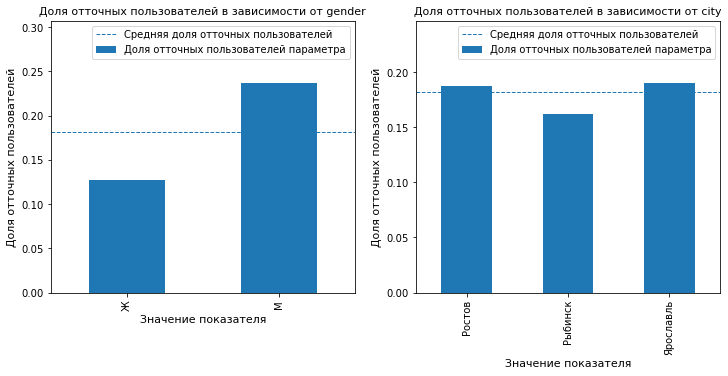

In [41]:
fig = plt.figure(figsize=(12,5))

for i, name in enumerate(['gender', 'city']):
    ax = plt.subplot(1, 2, i+1)
    (
        df.pivot_table(index=name, values='churn', aggfunc='mean')
        .plot(kind='bar', ax=ax, legend=False)
    )
    ax.set_title(f'Доля отточных пользователей в зависимости от {name}', size=11)
    ax.set_xlabel(f'Значение показателя', size=11)
    ax.set_ylabel('Доля отточных пользователей', size=11)
    ax.axhline(y=df.churn.mean(), linestyle='--', linewidth=1, label='Средняя доля отточных пользователей')
    ax.legend().get_texts()[1].set_text('Доля отточных пользователей параметра')
    ax.set_ylim(top=(df.pivot_table(index=name, values='churn', aggfunc='mean').max().values[0])*1.3)

plt.show()

Доля отточных пользователей среди мужчин больше. Показатель оттока практически не зависит от города расположения филиала банка.

Посмотрим доли отточных клиентов зависимости параметров `equity`, `products`, `credit_card`, `last_activity`.

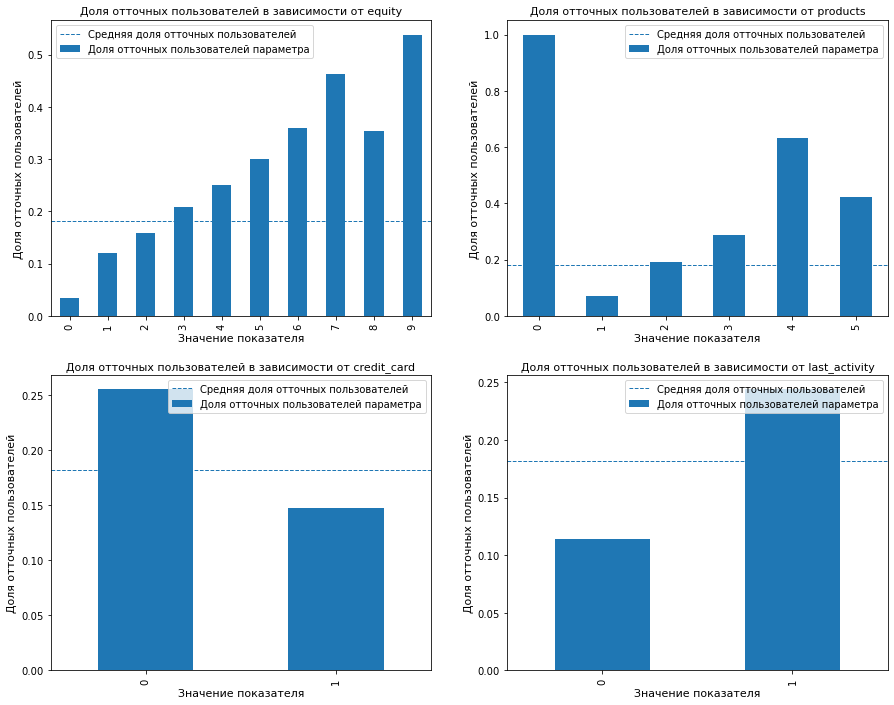

In [42]:
mask = df.select_dtypes(exclude=['object']).apply(pd.Series.nunique) <=10

fig = plt.figure(figsize=(15,25))

for i, name in enumerate(mask.index[mask].drop(['churn', 'is_man', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль'])):
    ax = plt.subplot(int(np.ceil(len(mask.index[mask].drop('churn'))/2)), 2, i+1)
    (
        df.pivot_table(index=name, values='churn', aggfunc='mean')
        .plot(kind='bar', ax=ax, legend=False)
    )
    ax.set_title(f'Доля отточных пользователей в зависимости от {name}', size=11)
    ax.set_xlabel(f'Значение показателя', size=11)
    ax.set_ylabel('Доля отточных пользователей', size=11)
    ax.axhline(y=df.churn.mean(), linestyle='--', linewidth=1, label='Средняя доля отточных пользователей')
    ax.legend().get_texts()[1].set_text('Доля отточных пользователей параметра')

plt.show()

По показателю equity клиенты имеют показатель оттока выше среднего по датафрейму в диапазоне 3-9. Клиенты с более высоким показателем оттока пользуются 3 и более продуктами банка (с параметром products = 0, где доля отточных пользователей равняется 1 в датафрейме всего один пользователь), не имеют кредитной карты и являются активными пользователями.

Составим таблицу, в которой покажем портрет отточного и неотточного пользователя по всем параметрам. По зарплате, возрасту и балансу выведем среднее значение для каждой из групп, для количества продуктов, баллов собственности и принадлежности к филиалу какого-либо города - медианное, также добавим моды по городу и полу.

In [43]:
t = pd.DataFrame(
    index=['Количество клиентов',
        'Средняя зарплата',
        'Средний возраст',
        'Средний баланс',
        'Медианное количество продуктов',
        'Медианное количество баллов собственности',
        'Мода по городу',
        'Мода по полу',
        'Медиана по городу Ростов',
        'Медиана по городу Рыбинск',
        'Медиана по городу Ярославль'],
    columns=['Отток', 'Не отток', 'Относит. разница, %'])

In [44]:
for i, name in enumerate(['Не отток', 'Отток']):
    lst = []
    lst.append(df[df.churn == i].shape[0])
    lst.append(round(df[df.churn == i]['est_salary'].mean(), 2))
    lst.append(round(df[df.churn == i]['age'].mean(), 2))
    lst.append(round(df[df.churn == i]['balance'].mean(), 2))
    lst.append(df[df.churn == i]['products'].median())
    lst.append(df[df.churn == i]['equity'].median())
    lst.append(st.mode(df[df.churn == i]['city'])[0][0])
    lst.append(st.mode(df[df.churn == i]['gender'])[0][0])
    lst.append(df[df.churn == i]['city_Ростов'].median())
    lst.append(df[df.churn == i]['city_Рыбинск'].median())
    lst.append(df[df.churn == i]['city_Ярославль'].median())
    t[name] = lst
    
# для параметров "средняя зарплата", "средний возраст" и "средний баланс" посчитаем относительную разницу
t.iloc[1:4, 2] = abs(t.iloc[1:4, 0] - t.iloc[1:4, 1])/t.iloc[1:4, 1] * 100

Выведем составленную таблицу на экран.

In [45]:
t

,Отток,Не отток,"Относит. разница, %"
Количество клиентов,1820,8180,NaN
Средняя зарплата,148243.01,147783.2,0.311138
Средний возраст,41.45,43.01,3.627063
Средний баланс,1133993.27,733982.59,54.498661
Медианное количество продуктов,2.0,2.0,NaN
Медианное количество баллов собственности,4.0,3.0,NaN
Мода по городу,Ярославль,Ярославль,NaN
Мода по полу,М,Ж,NaN
Медиана по городу Ростов,0.0,0.0,NaN
Медиана по городу Рыбинск,0.0,0.0,NaN


**Портрет отточного клиента:**
Зарплата 148243 руб., возраст 41.5 года, баланс 1133993 руб., пользуется 2 продуктами банка, количество баллов собственности: 4, является клиентом филиала в Ярославле, пол мужской.

**Портрет неотточного клиента:**
Зарплата 147783 руб., возраст 43 года, баланс 733983 руб., пользуется 2 продуктами банка, количество баллов собственности: 3, является клиентом филиала в Ярославле, пол мужской.

Посмотрим на линейные зависимости признаков с показателем оттока. Для этого построим матрицу корреляции Пирсона.

[]

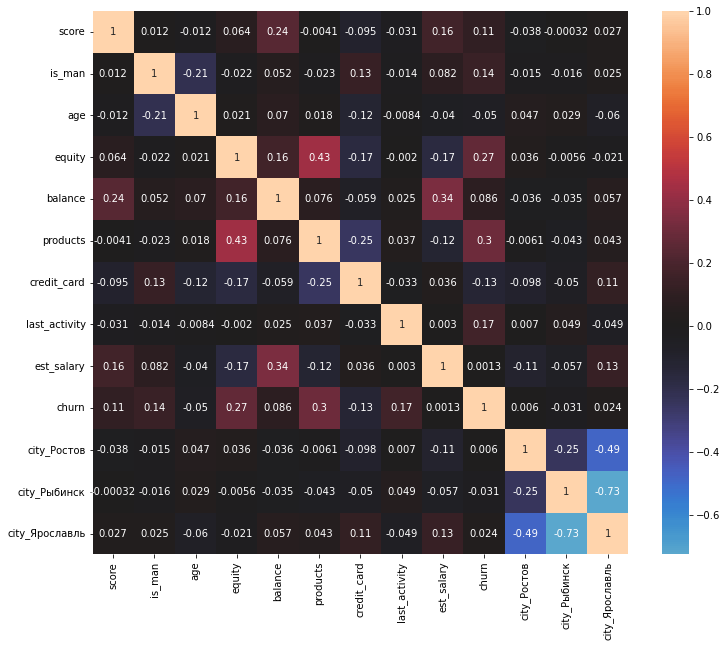

In [46]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), center=0, annot=True)
plt.plot()

Признаки `equity`, `last_activity`, `is_man (sex)`, `balance`, `score` имеют слабую положительную корреляцию с показателем оттока. У показателя `credit_card` слабая отрицательная корреляция. `products` имеет умеренную положительную корреляцию с показателем оттока.

Построим также матрицу с помощью библиотеки `phik`, чтобы посмотреть на корредяцию признаков с учетом нелинейной зависимости.

Подготовим и сохраним в переменную `dfml` датасет, в котором оставим только числовые и закодированные категориальные переменные.

In [47]:
dfml = (
    pd.get_dummies(df, columns=['gender'], prefix=['sex'])
    .drop(['is_man'], axis=1)
    .select_dtypes(exclude=('object'))
)

In [48]:
dfml

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,sex_Ж,sex_М
0,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,892.0,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,814.0,27.0,1,78144.65,1,0,1,18943.64,0,0,1,0,0,1
9996,894.0,46.0,0,NaN,1,1,0,196898.29,0,0,0,1,0,1
9997,903.0,24.0,0,NaN,2,1,1,108905.09,0,0,0,1,0,1
9998,777.0,68.0,3,865457.97,3,0,1,86874.90,0,0,0,1,1,0


Построим матрицу корреляции с учетом нелинейных зависимостей.

[]

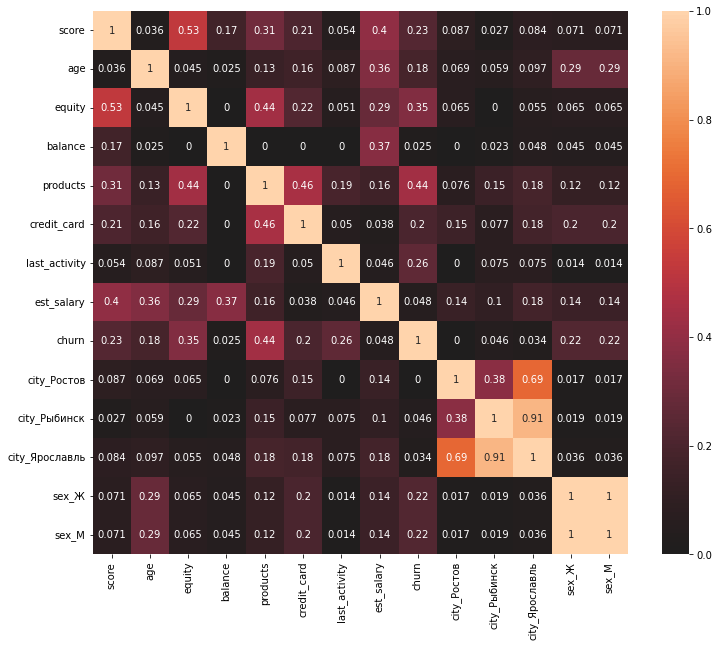

In [49]:
plt.figure(figsize=(12,10))
sns.heatmap(
    dfml.phik_matrix(interval_cols=['age', 'score', 'balance', 'est_salary']), center=0, annot=True)
plt.plot()

Выведем отдельно столбец корреляции признаков с признаком оттока.

[]

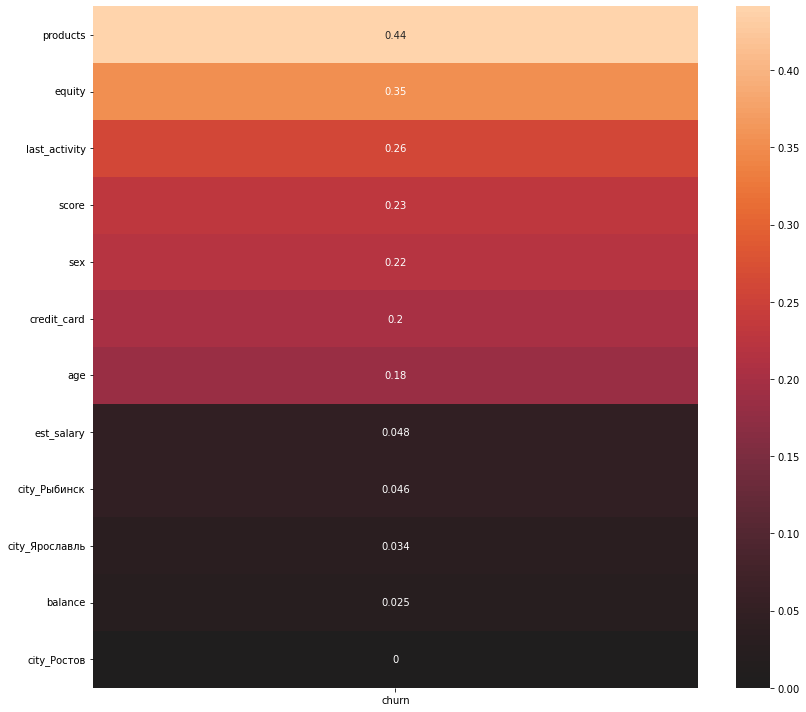

In [50]:
plt.figure(figsize=(12,10))
sns.heatmap(
    dfml.drop(columns=('sex_Ж')).rename(columns=({'sex_М': 'sex'}))
    .phik_matrix(interval_cols=['age', 'score', 'balance', 'est_salary'])['churn']
    .sort_values(ascending=False)
    .drop('churn')
    .to_frame(), center=0, annot=True)
plt.tight_layout()
plt.plot()

С учетом нелинейных зависимостей признаки `products` и `equity` имеют умеренную корреляцию с признаком оттока. Также умеренно коррелируют с ним признаки `last_activity`, `score`, `sex`, `age` и `credit_card`. 

## Проверка статистических гипотез

- Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.
- Возраст отточного клиента больше, чем неотточного.

Перед проверкой гипотез посмотрим на распределение значений исследуемых переменных, в зависимости от чего будем применять тот или иной критерий.

### Гипотеза 1. Доходы отточных и неотточных клиентов равны

Сформулируем нулевую и альтернативную гипотезы.
- H0 - доходы отточных и неотточных клиентов равны
- H1 - доходы отточных и неотточных клиентов не равны

Перед выбором теста для проверки гипотезы, исследуем распределение проверяемого в гипотезе параметра.

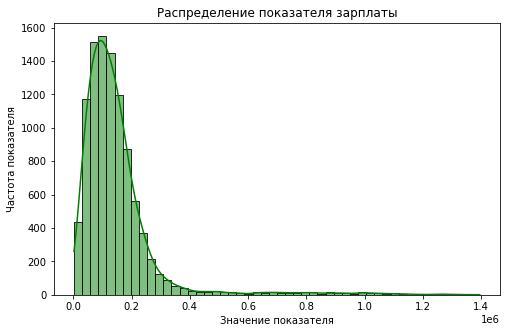

In [51]:
plt.figure(figsize=(8,5))
sns.histplot(df['est_salary'], kde=True, bins=50, color='green')
plt.xlabel('Значение показателя')
plt.ylabel('Частота показателя')
plt.title('Распределение показателя зарплаты')
plt.show()

На гистограмме изображено жирнохвостовое распределение с большим количеством аномальных значений. Распределение не является нормальным.

Для более точного обоснования наших выводов применим к распределению тест Андерсона-Дарлинга, который позволит определить нормальность нашего распределения при заданном критическом уровне статистической значимости.

In [52]:
alpha = .05 # зададим критический уровень статистической значимости

results = st.anderson(df['est_salary'], dist='norm')
# запишем результаты теста в переменную results
ind = list(results[2]).index(alpha*100)
# определим в результатах индекс критического значения статистики при заданном alpha

if list(results[1])[ind] < results[0]:
    print(f'Тестовая статистика {round(results[0], 3)} превышает ее критическое значение {list(results[1])[ind]}\
 при alpha={alpha}: распределение параметра не нормально')
else:
    print(f'Тестовая статистика {round(results[0], 3)} не превышает ее критическое значение {list(results[1])[ind]}\
 при alpha={alpha}: распределение параметра нормально')

Тестовая статистика 820.541 превышает ее критическое значение 0.787 при alpha=0.05: распределение параметра не нормально


Т.к. распределение не является нормальным и имеет множество аномальных значений, для проверки гипотезы будем использовать непараметрический тест Уилкоксона-Манна-Уитни, который устойчив к выбросам.

In [53]:
results = st.mannwhitneyu(df[df['churn'] == 1]['est_salary'], df[df['churn'] == 0]['est_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  0.000243559272811695
Отвергаем нулевую гипотезу: разница статистически значима


**Вывод:** в результате проверки гипотезы о равенстве доходов отточных и неотточных пользователей при критическом уровне статзначимости 5% принята альтернативная гипотеза: доходы отточных и неотточных клиентов не равны.

### Гипотеза 2. Возраст отточного клиента больше, чем неотточного

Сформулируем нулевую и альтернативную гипотезы.
- H0 - возраст отточного клиента больше возраста неотточного клиента
- H1 - возраст отточного клиента не больше возраста неотточного клиента

Перед выбором теста для проверки гипотезы, исследуем распределение проверяемого в гипотезе параметра.

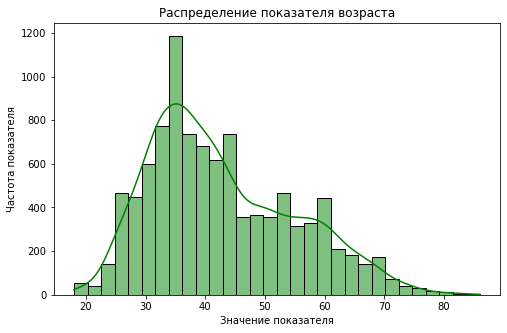

In [54]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], kde=True, bins=30, color='green')
plt.xlabel('Значение показателя')
plt.ylabel('Частота показателя')
plt.title('Распределение показателя возраста')
plt.show()

Распределение не является нормальным.

Для более точного обоснования наших выводов применим к распределению тест Андерсона-Дарлинга, который позволит определить нормальность нашего распределения при заданном критическом уровне статистической значимости.

In [55]:
alpha = .05 # зададим критический уровень статистической значимости

results = st.anderson(df['age'], dist='norm')
# запишем результаты теста в переменную results
ind = list(results[2]).index(alpha*100)
# определим в результатах индекс критического значения статистики при заданном alpha

if list(results[1])[ind] < results[0]:
    print(f'Тестовая статистика {round(results[0], 3)} превышает ее критическое значение {list(results[1])[ind]}\
 при alpha={alpha}: распределение параметра не нормально')
else:
    print(f'Тестовая статистика {round(results[0], 3)} не превышает ее критическое значение {list(results[1])[ind]}\
 при alpha={alpha}: распределение параметра нормально')

Тестовая статистика 139.23 превышает ее критическое значение 0.787 при alpha=0.05: распределение параметра не нормально


Т.к. распределение не является нормальным и имеет множество аномальных значений, для проверки гипотезы будем использовать непараметрический тест Уилкоксона-Манна-Уитни, который устойчив к выбросам.

In [56]:
results = st.mannwhitneyu(df[df['churn'] == 1]['age'], df[df['churn'] == 0]['age'], alternative='greater')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  0.9999977111464564
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


**Вывод:** в результате проверки гипотезы о том, что возраст отточного клиента больше, чем неотточного при критическом уровне статзначимости 5% принята нулевая гипотеза: возраст отточного клиента больше возраста неотточного клиента.

## Подведение промежуточных итогов

**EDA**

По гистограммам распределения выделены наиболее характерные диапазоны для сегментации клиентов в условиях нашей задачи: показатель score 820-940, показатель возраста в диапазоне 24-38 лет., баланс более 700 тыс. руб., зарплата более 80 тыс. руб.

Доля отточных пользователей среди мужчин больше. По показателю equity клиенты имеют показатель оттка выше среднего по датафрейму в диапазоне 3-9. Клиенты с более высоким показателем оттока пользуются 3 и более продуктами банка, не имеют кредитной карты и являются активными пользователями.

**Портреты отточного и неотточного клиента**

*Портрет отточного клиента:*
Зарплата 148243 руб., возраст 41.5 года, баланс 1133993 руб., пользуется 2 продуктами банка, количество баллов собственности: 4, является клиентом филиала в Ярославле, пол мужской.

*Портрет неотточного клиента:*
Зарплата 147783 руб., возраст 43 года, баланс 733983 руб., пользуется 2 продуктами банка, количество баллов собственности: 3, является клиентом филиала в Ярославле, пол мужской.

**Исследование корреляции Пирсона**

Признаки `equity`, `last_activity`, `is_man (sex)`, `balance`, `score` имеют слабую положительную корреляцию с показателем оттока. У показателя `credit_card` слабая отрицательная корреляция. `products` имеет умеренную положительную корреляцию с показателем оттока.

**Исследование корреляции с учетом нелинейных зависимостей**

С учетом нелинейных зависимостей признаки `products` и `equity` имеют умеренную корреляцию с признаком оттока. Также умеренно коррелируют с ним признаки `last_activity`, `score`, `sex`, `age` и `credit_card`. 

**Гипотеза 1. Доходы отточных и неотточных клиентов равны**

В результате проверки гипотезы о равенстве доходов отточных и неотточных пользователей при критическом уровне статзначимости 5% принята альтернативная гипотеза: доходы отточных и неотточных клиентов не равны.

**Гипотеза 2. Возраст отточного клиента больше, чем неотточного**

В результате проверки гипотезы о том, что возраст отточного клиента больше, чем неотточного при критическом уровне статзначимости 5% принята нулевая гипотеза: возраст отточного клиента больше возраста неотточного клиента.

## Выделение сегментов отточных пользователей

В результате разведочного анализа данных мы выделили диапазоны параметров для клиентов с наибольшим показателем оттока. Данные диапазоны значений параметров будем использовать при выделении сегментов пользователей. Перед началом работы выполним категоризацию переменных в соответствии с указанными диапазонами значений.

Зададим переменным `score`, `age`, `est_salary`, `balance`, `products`, `equity` категории, в зависимости от диапазонов значений (жирным шрифтом указаны категории, наиболее характерные по доле отточных клиентов):

**score**
- 1 (0-820)
- **2 (821-940)**
- 3 (940-1000)

**age**
- 1 (18-23)
- **2 (24-38)**
- 3 (39-49)
- **4 (50-61)**
- 5 (62-max)

**est_salary**
- 1 (0-80000)
- **2 (80001-max)**

**balance**
- 1 (0)
- 2 (1-70000)
- **3 (70001-max)**

**products**
- 1 (0)
- 2 (1-2)
- **3 (3-5)**

**equity**
- 1 (0-2)
- **2 (3-9)**

Также выделим для дальнейшего анализа активных клиентов и клиентов мужского пола.

Для дальнейшей работы из рабочего датафрейма исключим столбцы типа object и сохраним его в переменную `df_cat`. 

In [57]:
df_cat = df.select_dtypes(exclude=('object'))

Создадим список, в котором будет указано название столбца, которому присваиваются категории и список, в котором указаны границы диапазонов.

In [58]:
lst = [
    ['score', [-1, 820, 940, 1000]],
    ['age', [17, 23, 38, 49, 61, np.inf]],
    ['est_salary', [-1, 80000, np.inf]],
    ['balance', [-1, 0, 70000, np.inf]],
    ['products', [-1, 0, 2, 5]],
    ['equity', [-1, 2, 9]]
]

С помощью цикла перезапишем столбцы в датафрейме значениями категорий.

In [59]:
for i in lst:
    df_cat[i[0]] = pd.cut(df_cat[i[0]], i[1], labels=[i+1 for i in range(len(i[1])-1)])

Выведем датафрейм на экран.

In [60]:
df_cat.head()

,score,is_man,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль
0,2,0,2,1,2,2,0,1,1,1,0,1,0
1,2,0,2,2,3,3,1,0,2,0,0,1,0
2,2,0,2,1,NaN,2,1,1,2,0,0,1,0
3,2,0,4,2,3,2,0,1,2,1,0,0,1
4,1,1,2,2,2,2,1,0,1,1,0,0,1


Создадим список с указанием категорий для параметров, где отточные пользователи преобладают над неотточными. Элементы данного списка в дальнейшем будут применяться для фильтрации по ним датафрейма.

In [61]:
important = [
    'score == 2',
    'age == 2',
    'age == 4',
    'est_salary == 2',
    'balance == 3',
    'products == 3',
    'equity == 2',
    'is_man == 1',
    'last_activity == 1'
]

Для каждой комбинации из указанных выше условий (комбинация состоит из не более 3 элементов) посчитаем долю пользователей, отфильтрованных по комбинации условий и показатель оттока.

In [62]:
imp_df = pd.DataFrame(columns = ['sign1', 'sign2', 'sign3', 'share', 'churn'])

for i in important:
    for j in important:
        for k in important:
            imp_df.loc[imp_df.shape[0]] = [i,
                                           j,
                                           k,
                                           df_cat.query(i).query(j).query(k).shape[0] / df_cat.shape[0],
                                           df_cat.query(i).query(j).query(k)['churn'].mean()
            ]

Выведем датафрейм на экран.

In [63]:
imp_df.head()

,sign1,sign2,sign3,share,churn
0,score == 2,score == 2,score == 2,0.5974,0.228825
1,score == 2,score == 2,age == 2,0.2612,0.273354
2,score == 2,score == 2,age == 4,0.1143,0.297463
3,score == 2,score == 2,est_salary == 2,0.4493,0.245716
4,score == 2,score == 2,balance == 3,0.4413,0.305914


Преобразуем датафрейм для анализа.

In [64]:
# отфильтруем строки, для которых показатель оттока ниже показателя оттока по рабочему датафрейму, 
# а также сегменты, которые составляют долю менее 10% от общего количества клиентов в датафрейме
imp_df = imp_df[(imp_df['churn'] > df['churn'].mean()) & (imp_df['share'] > 0.1)]

# добавим параметр "вес", полученный путем перемножения доли пользователей на показатель оттока
# данный параметр показывает долю отточных пользователей сегмента относительно общего количества пользователей
imp_df['weight'] = (imp_df['share'] * imp_df['churn'])

# отсортируем датафрейм по показателю оттока
imp_df = imp_df.sort_values('churn', ascending=False)

# установим названия условий в качестве индексов и удалим дубликаты строк
imp_df = imp_df.set_index(['sign1', 'sign2', 'sign3']).drop_duplicates()

Выведем на экран 25 комбинаций условий с наиболее высоким показателем оттока.

In [65]:
imp_df.head(25).style.background_gradient(cmap='coolwarm')

На основе резельтатов данной таблицы выделим сегменты пользователей с наибольшим показателем оттока. Также стоит обратить внимание на сегменты с большой долей клиентов во всем датасете, имеющих высокий показатель оттока. Данные сегменты нужны для проведения рекламной компании, поэтому при выделении сегментов будем учитывать корреляцию некоторых признаков между собой.

*1. Активные пользователи с рейтингом 821-940 и балансом более 70 тыс. руб.*

*2. Активные пользователи мужского пола с количеством баллов собственности 3 и более*

*3. Активные пользователи возрастом 24-38 лет и рейтингом 821-940*

*4. Пользователи с балансом более 70 тыс. руб., которые пользуются 3 и более продуктами банка*

## Приоритезация сегментов и рекомендации по работе с сегментами

Приоритезацию сегментов выполним на основании параметра, который показывает долю отточных пользователей сегмента от общего количества пользователей (без разделения на сегменты). Снижать показатель оттока для сегментов с большим показателем доли отточных пользователей сегмента от общего количества пользователей наиболее эффективно.

Создадим список с описанием сегментов `names` и список с условиями для фильтрации каждого сегмента `segments`.

In [66]:
names = [
    'Активные пользователи с рейтингом 821-940 и балансом более 70 тыс. руб.',
    'Активные пользователи мужского пола с количеством баллов собственности 3 и более',
    'Активные пользователи возрастом 24-38 лет и рейтингом 821-940',
    'Пользователи с балансом более 70 тыс. руб., которые пользуются 3 и более продуктами банка'
]

segments = [
    'last_activity == 1 & score > 820 & score <= 940 & balance > 70000',
    'last_activity == 1 & gender == "М" & equity >= 3',
    'last_activity == 1 & age >= 24 & age <= 38 & score > 820 & score <= 940',
    'balance > 70000 & products >= 3'
]

Создадим датафрейм `priority`, в котором будет показано описание сегмента, доля клиентов сегмента от общего количества клиентов, показатель оттока сегмента, доля отточных клиентов сегмента от общего количества клиентов и отсортируем значения по долу отточных клиентов сегмента от общего количества клиентов и проранжируем сегменты.

In [67]:
# создаем пустой датафрейм с нужными столбцами
priority = pd.DataFrame(columns=['segment_describe', 'share_of_total', 'churn', 'share_churn_of_total'])

# заполним датафрейм, посчитаем показатели
for i, j in zip(names, segments):
    priority.loc[priority.shape[0]] = [
        i,
        round((df.query(j).shape[0]/df.shape[0]), 2),
        round(df.query(j)['churn'].mean(), 2), 
        round((df.query(j).shape[0]/df.shape[0]) * (df.query(j)['churn'].mean()), 3)
    ] 

# установим 'segment_describe' в качестве индекса
priority = priority.set_index('segment_describe').sort_values('share_churn_of_total', ascending=False)

# проранжируем сегменты
priority['rank'] = [i for i in range(1, priority.shape[0]+1)]

Выведем итоговый датафрейм с приоритетом и параметрами каждого сегмента на экран.

In [68]:
priority

,share_of_total,churn,share_churn_of_total,rank
segment_describe,,,,
Активные пользователи с рейтингом 821-940 и балансом более 70 тыс. руб.,0.22,0.46,0.102,1
Активные пользователи мужского пола с количеством баллов собственности 3 и более,0.14,0.46,0.065,2
Активные пользователи возрастом 24-38 лет и рейтингом 821-940,0.14,0.42,0.059,3
"Пользователи с балансом более 70 тыс. руб., которые пользуются 3 и более продуктами банка",0.15,0.40,0.059,4


Для наглядности выведем столбчатую диаграмму.

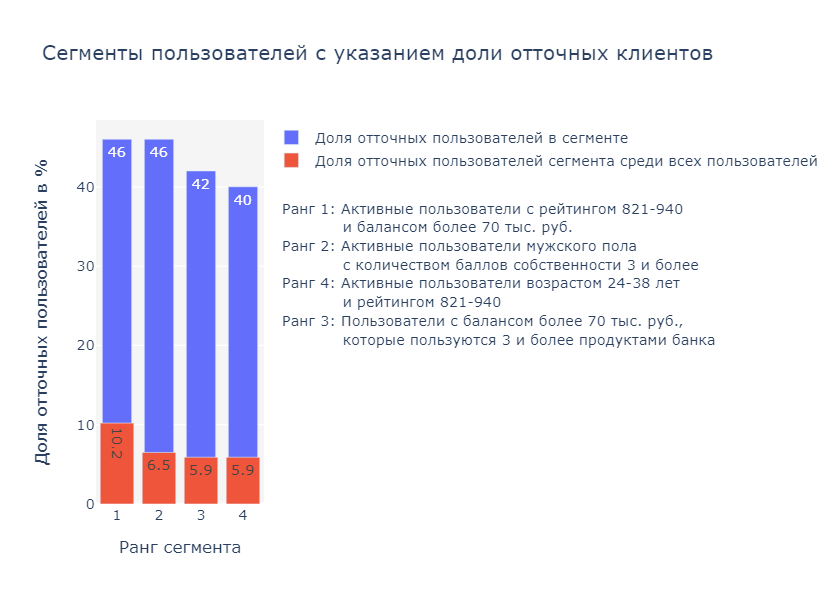

In [72]:
fig = go.Figure(data=[
    go.Bar(
        name='Доля отточных пользователей в сегменте', x=priority['rank'], y=priority['churn']*100,
        text=round(priority['churn']*100, 2), width=0.7),
    go.Bar(
        name='Доля отточных пользователей сегмента среди всех пользователей', x=priority['rank'],
        y=priority['share_churn_of_total']*100, text=round(priority['share_churn_of_total']*100, 2))
])

fig.update_layout(
    yaxis_title='Доля отточных пользователей в %', xaxis_title='Ранг сегмента', plot_bgcolor='whitesmoke',
    title='Сегменты пользователей с указанием доли отточных клиентов'
)

fig.add_annotation(text=(
    'Ранг 1: Активные пользователи с рейтингом 821-940<br>\
            и балансом более 70 тыс. руб.<br>\
Ранг 2: Активные пользователи мужского пола<br>\
            с количеством баллов собственности 3 и более<br>\
Ранг 4: Активные пользователи возрастом 24-38 лет<br>\
            и рейтингом 821-940<br>\
Ранг 3: Пользователи с балансом более 70 тыс. руб.,<br>\
            которые пользуются 3 и более продуктами банка'), 
                    align='left', showarrow=False, xref='paper', yref='paper', x=3.7, y=0.8,  )

fig.update_layout(barmode='overlay')
fig.show()

**Рекомендации по работе с сегментами**

*Активные пользователи с рейтингом 821-940 и балансом более 70 тыс. руб.*

Данному сегменту пользователей целесообразно предлагать кредитные продукты и вклады на выгодных условиях, либо установить/увеличить процент на остаток средств по карте (также возможно предложить клиенту интересные для него условия по кэшбэку). Предложение брокерских услуг (если такие предоставляются банком) также может дать пользователю повод оставаться клиентом банка.

*Активные пользователи мужского пола с количеством баллов собственности 3 и более*

Предложение страховых продуктов (в зависимости от типов собственности клиента: авто, недвижимость, бизнес и т.д.) может изменить решение клиентов об уходе из банка.

*Активные пользователи возрастом 24-38 лет и рейтингом 821-940*

Для пользователей данного сегмента целесообразно предлагать ипотечные продукты, потребительские и иные кредиты. Также для данной возрастной категории актуальным является предложение брокерских услуг (если такие предоставляются банком).

*Пользователи с балансом более 70 тыс. руб., которые пользуются 3 и более продуктами банка*

Целесообразно по мере возможности предложить более выгодные условия по тем продуктам, которыми пользуется клиент. Для такого клиента по мере возможности целесообразно установить/увеличить процент на остаток средств по карте (также возможно предложить клиенту интересные для него условия по кэшбэку). Предложение брокерских услуг (если такие предоставляются банком) также может дать пользователю повод оставаться клиентом банка.